In [70]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [71]:
import numpy as np
import pandas as pd

In [72]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [73]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData, Table,Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()


In [74]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [75]:
#with sqlite3.connect(db_path) as db:
# reflect an existing database into a new model
meta = MetaData(engine)
Base = automap_base(bind=engine, metadata=meta)

#calling prepare() to set up mapped classes and relationships
Base.prepare(engine, reflect=True)


In [76]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [77]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [78]:
#mapped classes are ready
Measurements, Stations = Base.classes.measurement, Base.classes.station
Base.metadata.create_all(engine)
date = session.query(Measurements.date).order_by(Measurements.date).all()
last_date = date[-1][0]
print(last_date)

2017-08-23


# Exploratory Climate Analysis

2016-08-23


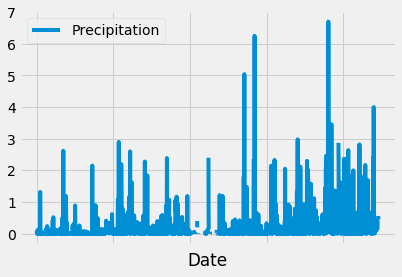

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)
# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
#print (scores)
# Save the query results as a Pandas DataFrame and set the index to the date column
df_measure = pd.DataFrame(scores, columns=['Date', 'Precipitation'])
#df.head()
df_measure = df_measure.set_index('Date')
#df.head()
# Sort the dataframe by date
df_measure.sort_values('Date')
df_measure.head()

# Use Pandas to calculate the summary statistics for the precipitation data
df_measure.plot()

In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_lastyear.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [81]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(stations)

9


In [82]:
# What are the most active stations? (i.e. what stations have the most rows)?
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter (Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

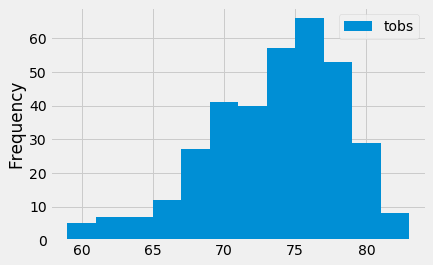

In [84]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year).all()
df_temperature = pd.DataFrame(temperatures, columns=['tobs'])
df_temperature.plot.hist(bins=12)

In [85]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [86]:
#Use your previous function 'calc_temps' to calculate the tmin, tavg, and tmax
#for your trip using the previous year's data for those same dates
v = calc_temps('2011-02-28', '2011-03-05')
v[0]

(61.0, 69.75510204081633, 75.0)

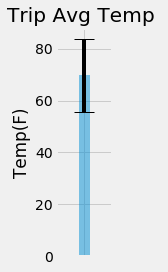

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = v[0][2]-v[0][0]
fig, ax = plt.subplots(figsize=(2,4))
ax.bar(1,v[0][1], yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10,width=0.2)
ax.set_xlim(0.5, 1.5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp ')
plt.tight_layout()
plt.show()

In [88]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_prcp = session.query(Stations.name,Stations.station,Stations.latitude,Stations.longitude,Stations.elevation, func.avg(Measurements.prcp)).group_by(Stations.station).filter(Measurements.date >= '2011-02-28').filter(Measurements.date <= '2011-03-05').filter(Stations.station == Measurements.station).order_by(func.avg(Measurements.prcp).desc()).all()
station_prcp

[('UPPER WAHIAWA 874.3, HI US',
  'USC00518838',
  21.4992,
  -158.0111,
  306.6,
  0.5825),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  21.5213,
  -157.8374,
  7.0,
  0.392),
 ('WAIHEE 837.5, HI US',
  'USC00519281',
  21.45167,
  -157.84888999999998,
  32.9,
  0.37166666666666665),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5,
  0.365),
 ('MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  21.3331,
  -157.8025,
  152.4,
  0.24166666666666667),
 ('KANEOHE 838.1, HI US', 'USC00513117', 21.4234, -157.8015, 14.6, 0.24),
 ('WAIKIKI 717.2, HI US',
  'USC00519397',
  21.2716,
  -157.8168,
  3.0,
  0.22999999999999998),
 ('HONOLULU OBSERVATORY 702.2, HI US',
  'USC00511918',
  21.3152,
  -157.9992,
  0.9,
  0.126),
 ('PEARL CITY, HI US', 'USC00517948', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


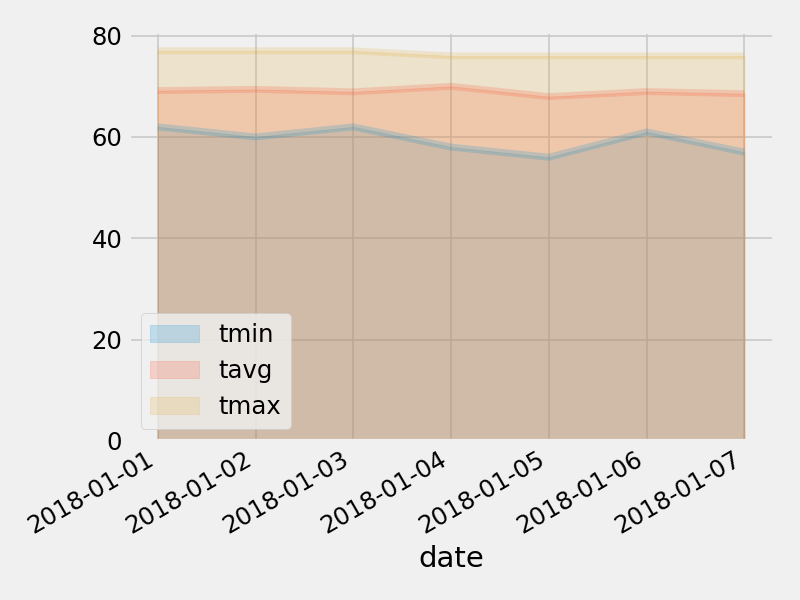

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
